In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import optimize
import random
from tabulate import tabulate
from scipy.interpolate import RegularGridInterpolator

In [2]:
T = pd.read_csv('/Users/siyangwei/Documents/ANES_datasets/anes_timeseries_cdf_csv_20220916/anes_timeseries_cdf_csv_20220916.csv',
                low_memory=False)

In [3]:
T['VCF0101'] = pd.to_numeric(T['VCF0101'],errors='coerce',downcast='integer')
T = T[T['VCF0101']<=80]   # restrict age <= 80
T['VCF0004'] = pd.to_numeric(T['VCF0004'],errors='coerce',downcast='integer')
year = T['VCF0004']       
yr = set(year)      # extract survey years
age = T['VCF0101']       # extract respondent age
M = pd.concat([year,age],axis=1,join='inner')

In [4]:
# Filter binary questions
coln = len(T.columns)  # number of columns(variables)
questions = {}
for i in range(153,coln):
    values = set(T.iloc[:,i])
    values = [str(x) for x in values]
    avalues = [x for x in values if x.strip()]
    if len(avalues) <= 4 and '1' in avalues and '2' in avalues and '3' not in avalues:
        questions[T.columns[i]] = avalues

In [5]:
removekeys = ['VCF0358','VCF0359','VCF0360','VCF0361','VCF0370','VCF0371','VCF0372','VCF0373',
              'VCF0701','VCF0702','VCF0714','VCF0716','VCF0717','VCF0718','VCF0719','VCF0720',
             'VCF0721','VCF0722','VCF0724','VCF0725','VCF0726','VCF0727','VCF0729','VCF0730',
             'VCF0737','VCF0739','VCF0740','VCF0741','VCF0742',
              'VCF0903','VCF0904','VCF0905','VCF0978',
              'VCF1011','VCF1012','VCF1013',
             'VCF9030a','VCF9030b','VCF9030c','VCF9054','VCF9217','VCF9218','VCF9224','VCF9256',
             'VCF9257','VCF9258','VCF9260','VCF9261','VCF9262','VCF9265','VCF9278','VCF9280',
             'VCF9281','VCF9282']
for key in removekeys:
    del questions[key]

In [6]:
keylist = list(questions)
keylistlong = []
for k in keylist:
    col = T[k].astype('category')
    yearsur = year[(col == '1') | (col == '2')] # survey years
    yrsur = set(yearsur)
    if len(yrsur) >= 10:
        keylistlong.append(k)

In [7]:
keylistlong

['VCF0311',
 'VCF0312',
 'VCF0450',
 'VCF0501',
 'VCF0502',
 'VCF0605',
 'VCF0612',
 'VCF0619',
 'VCF0620',
 'VCF0621',
 'VCF0704a',
 'VCF0707',
 'VCF0708',
 'VCF0711',
 'VCF0816',
 'VCF0823',
 'VCF0829',
 'VCF0846',
 'VCF9236',
 'VCF9243']

In [8]:
# import real US matrix
Wim = pd.read_excel('/Users/siyangwei/Documents/contact_matrices_152_countries/MUestimates_all_locations_2.xlsx',
                   sheet_name = 53, header = None)
Wim = Wim.to_numpy()

/Users/siyangwei/anaconda3/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [23]:
# preprocess interaction matrix
N = 16
WUS = np.copy(Wim)
# the real US matrix (scale entries by maximum row sum)
#rowsumax = max(np.sum(Wim, axis=1))
#WUS = WUS/rowsumax
#WUS = np.zeros([N,N])
# the real US matrix
#WUS[0,:] = Wim[0,:]/sum(Wim[0,:])
#WUS[1:N,:] = Wim[1:N,:]/2; # scale entries of W to speed up convergence

# constant matrix W
Wc = np.ones([N,N])
#Wc[1:N,:] = Wc[1:N,:]*5

# symmetrized US matrix
# scale WUS such that the first row and col both sums to 1
Wnml = np.copy(WUS)
# sc = sum(WUS[1:N,0])/(1-Wnml[0,0])
# Wnml[1:N,0] = WUS[1:N,0]/sc
Wsym = (Wnml + np.transpose(Wnml))/2

# interpolate W to a matrix with 4-year gap
x = y = np.linspace(3, 78, 16)
# New domain (18.5, 22.5, ..., 78.5)
x_new = y_new = np.linspace(18.5, 78.5, 16)
# Create the interpolation function
interp_function = RegularGridInterpolator((x, y), Wsym, bounds_error=False, fill_value=None)
# Create a meshgrid for the points where we want to interpolate
X_new, Y_new = np.meshgrid(x_new, y_new)
# We need to create a list of points in the format that RegularGridInterpolator expects
# This is a list of (x, y) pairs
points_to_interpolate = np.c_[X_new.ravel(), Y_new.ravel()]
# Interpolate the function values at the new points
new_matrix_values = interp_function(points_to_interpolate)

# Reshape the interpolated values to a 16x16 grid
new_matrix = new_matrix_values.reshape(16, 16)
W4 = np.copy(new_matrix)

In [24]:
# matrix used for fit
W = np.copy(Wc)

In [310]:
# Analyze a question
varname = 'VCF0707'   
# 1970 type of this question, 0009: 0, 0010: 1, 0011: 2
weightvar = 'VCF0009z'
if varname == 'VCF0816':
    weightvar = 'VCF0011z'
weight = T[weightvar]  
var = T[varname]
var = T[varname].astype('category')
D = M.join(var,how='inner')
Dw = D.join(weight, how = 'inner')

In [311]:
I = np.zeros([len(yr),5,13])  # 3d array, year, type and type percentage, 13 age groups
#I = np.zeros([len(yr),5,16])
J = np.zeros([len(yr),5])  # 2d array, year, type and type percentage
yr = list(yr)
J[:,0] = yr

for j in range(13): # 13 age groups
#for j in range(16):    
    # extract data for age group j
    maskj = (age > 5*(j+3)) & (age <= 5*(j+4))
    #maskj = (age >= 4*j+17) & (age <= 4*j+20)
    Mag = Dw[maskj == True]
    
    # count for each year
    I[:,0,j] = yr
    for i in range(len(yr)):
        maskyr = (Mag['VCF0004'] == yr[i])
        Magyr = Mag[maskyr == True]
        # number of opinion 1 in year i, age group j
        I[i,1,j] = Magyr.loc[Magyr[varname] == '1', weightvar].sum()
        I[i,2,j] = Magyr.loc[Magyr[varname] == '2', weightvar].sum()
        #I[i,1,j] = sum(Magyr[varname] == '1')
        #I[i,2,j] = sum(Magyr[varname] == '2')
        # weighted number of opinion 1 in year i, all age groups
        J[i,1] += I[i,1,j]
        J[i,2] += I[i,2,j]

# delete the year without data for I and J
J2 = J[:,[1,2]]
J = J[~np.all(J2 == 0, axis = 1)]
t = J[:,0]
In = np.zeros([len(t),5,13])
#In = np.zeros([len(t),5,16])
for k in range(13):
#for k in range(16):
    ind = np.isin(I[:,0,k],t)
    In[:,:,k] = I[ind,:,k]

np.seterr(invalid='ignore') # ignore 0/0 error, will return NaN
# compute opinion 1/ population of each year
In[:,3,:] = In[:,1,:]/np.sum(In[:,[1,2],:],1)
In[:,4,:] = In[:,2,:]/np.sum(In[:,[1,2],:],1)

J[:,3] = J[:,1]/np.sum(J[:,[1,2]],1)
J[:,4] = J[:,2]/np.sum(J[:,[1,2]],1)

In [312]:
# Initial Conditions
tmax = int((t[-1]-t[0]+5)//5 + 1) # ceil division, time gap = age group diff = 5 years
taxis = np.arange(0,tmax)*5 + t[0]
#tmax =  math.ceil((t[-1]-t[0]+4)/4)
#taxis = np.arange(0,tmax)*4 + t[0]
# use the same initial condition as in dataset
p = np.zeros([N,tmax])

# deal with NaN values: replace NaN with average
# p0[np.isnan(p0)] = np.mean(p0[~np.isnan(p0)])
# intead of replacing with average, replace NaN with the next available value in this age group
for i in range(3,N):
#for i in range(N):
    if In[0,3,i-3] != In[0,3,i-3]:
    #if In[0, 3, i] != In[0, 3, i]:
        p[i,0] = next((x for x in In[:,3,i-3] if x == x))
        #p[i,0] = next((x for x in In[:,3,i] if x == x))
    else:
        p[i,0] = In[0,3,i-3]
        #p[i,0] = In[0,3,i]
        
p[0:3,0] = In[0,3,2:5] # IC for age 0-15: assume the same as IC for age 25-40
p0 = p[:,0]

In [313]:
t

array([1952., 1956., 1958., 1960., 1962., 1964., 1966., 1968., 1970.,
       1972., 1974., 1976., 1978., 1980., 1982., 1984., 1986., 1988.,
       1990., 1992., 1994., 1996., 1998., 2000., 2002., 2004., 2008.,
       2012., 2016., 2020.])

startyear = int(t[0])
d = [1, -1, -3, -5, -7, -9]
coblst = [startyear + 4*i for i in d] # cohort born years
for by in coblst: # track the cohorts 
    cohtrack = np.zeros([len(taxis), 5])
    cohtrack[:, 0] = taxis
    for i in range(len(taxis)):
        # extract data for this cohort
        maski = (age > max(taxis[i]-by-4,0)) & (age <= taxis[i]-by)
        Mag = Dw[maski == True]
        maskyr = (Mag['VCF0004'] == taxis[i])
        Magyr = Mag[maskyr == True]
        # number of opinion 1 in year i, age group j
        cohtrack[i,1] = Magyr.loc[Magyr[varname] == '1', weightvar].sum()
        cohtrack[i,2] = Magyr.loc[Magyr[varname] == '2', weightvar].sum()
        cohtrack[i,3] = cohtrack[i,1]/(cohtrack[i,1]+cohtrack[i,2])
    cname = str(by) + '-' + str(by+3)
    plt.plot(taxis, cohtrack[:, 3], label = cname)

plt.legend()
plt.show()

In [314]:
# simulation given be and ga
def sim(be,ga):
    p = np.zeros([N, tmax])
    p[:, 0] = p0
    for iter in range(tmax-1):
        p[0,iter+1] = np.dot(W[0,:],p[:,iter])/sum(W[0,:])
        for gp in range(1,N):
            p[gp,iter+1] = np.dot(p[gp-1,iter],(1-be[gp]*np.dot(W[gp,:],(1-p[:,iter])))) \
            + np.dot((1-p[gp-1,iter]),ga[gp]*np.dot(W[gp,:],p[:,iter]))
    return p

In [315]:
# sum squared error for constant, symmetric model, parameters c,a(numbers)
def Jcs(param):  
    c = param[0]
    a = param[1]
    sse = 0
    be = (c+a)*np.ones(N)
    ga = (c-a)*np.ones(N)
    p = sim(be,ga)
    for k in range(13):
    #for k in range(N):
        kindex = ~np.isnan(In[:,3,k])
        pinterp = np.interp(t[kindex], taxis, p[k+3,:])
        #pinterp = np.interp(t[kindex], taxis, p[k,:])
        sse += np.sum(np.square(pinterp - In[kindex,3,k]))
    return sse

In [316]:
def Jlsc(param):
    c = param[0]
    a = param[1]
    gg = param[2]
    sse = 0
    be = (c+a) * np.ones(N) + gg * np.arange(0, N)
    ga = (c - a) * np.ones(N) - gg * np.arange(0, N)
    p = sim(be, ga)
    for k in range(13):
    #for k in range(N):
        kindex = ~np.isnan(In[:,3,k])
        pinterp = np.interp(t[kindex], taxis, p[k+3,:])
        #pinterp = np.interp(t[kindex], taxis, p[k,:])
        sse += np.sum(np.square(pinterp - In[kindex,3,k]))
    return sse

In [317]:
def Jlsu(param):
    a1 = param[0]
    g1 = param[1]
    a2 = param[2]
    g2 = param[3]
    sse = 0
    be = a1 * np.ones(N) + g1 * np.arange(0, N)
    ga = a2 * np.ones(N) + g2 * np.arange(0, N)
    p = sim(be, ga)
    #for k in range(N):
    for k in range(13):
        kindex = ~np.isnan(In[:,3,k])
        pinterp = np.interp(t[kindex], taxis, p[k+3,:])
        #pinterp = np.interp(t[kindex], taxis, p[k,:])
        sse += np.sum(np.square(pinterp - In[kindex,3,k]))
    return sse

In [318]:
def Jsquare(param):
    c = param[0]
    a = param[1]
    gg = param[2]
    f = param[3]
    sse = 0
    be = (c+a) * np.ones(N) + gg * np.arange(0, N) + f * (np.arange(0, N)**2)
    ga = (c - a) * np.ones(N) - gg * np.arange(0, N) - f * (np.arange(0, N)**2)
    p = sim(be, ga)
    #for k in range(N):
    for k in range(13):
        kindex = ~np.isnan(In[:,3,k])
        pinterp = np.interp(t[kindex], taxis, p[k+3,:])
        #pinterp = np.interp(t[kindex], taxis, p[k,:])
        sse += np.sum(np.square(pinterp - In[kindex,3,k]))
    return sse

In [319]:
# backtracking line search
def BTLS(fun, w, dw, c = 0.01, gam = 0.5):
    fw = fun(w)
    dwnorm = np.linalg.norm(dw)
    d = -dw * 1e-5 / dwnorm     # descent direction
    deltaf = -c * 1e-5 * dwnorm
    newf = fun(w + d)
    t = 1
    while newf > fw + t * deltaf:
        t = gam * t
        newf = fun(w + t * d)
    return t, d

In [320]:
def grad_descent(fun,w_init,model,eps=1e-6, maxIter=500):
    w = w_init
    dw = np.ones(w_init.shape)
    W = []
    costs = []
    n_iter = 0
    
    W.append(w.copy())
    costs.append(fun(w))
    
    while n_iter < maxIter:
        # gradient of fun w.r.t. w
        dw = optimize.approx_fprime(w,fun,epsilon=1.4901161193847656e-08)
        if np.linalg.norm(dw) < 1e-8:
            break
            
        # adaptively choose step size
        lr, d = BTLS(fun, w, dw)
        #lr = 1e-6
        #if model == 'square':
        #    lr = 1e-7
        #lr = lr/max(np.abs(dw))
        w = w + lr * d
        
        cost = fun(w)
        
        # sanity check
        if model == 'cs':
            be = (w[0]+w[1])*np.ones(N)
            ga = (w[0]-w[1])*np.ones(N)
            if max(be)>1 or min(be)<0 or max(ga)>1 or min(ga)<0:
                break
            else:
                W.append(w.copy())
                costs.append(cost)
                n_iter += 1
                
        if model == 'lsc':   # linear, symmetric, coordinated
            be = (w[0]+w[1])*np.ones(N) + w[2]*np.arange(0,N)
            ga = (w[0]-w[1])*np.ones(N) - w[2]*np.arange(0,N)
            if max(be)>1 or min(be)<0 or max(ga)>1 or min(ga)<0:
                break
            else:
                W.append(w.copy())
                costs.append(cost)
                n_iter += 1
                
        if model == 'lsu':
            be = w[0] * np.ones(N) + w[1] * np.arange(0, N)
            ga = w[2] * np.ones(N) + w[3] * np.arange(0, N)
            if max(be)>1 or min(be)<0 or max(ga)>1 or min(ga)<0:
                break
            else:
                W.append(w.copy())
                costs.append(cost)
                n_iter += 1
                
        if model == 'square':     # square attractiveness
            be = (w[0] + w[1]) * np.ones(N) + w[2] * np.arange(0, N) + w[3] * (np.arange(0, N)**2)
            ga = (w[0] - w[1]) * np.ones(N) - w[2] * np.arange(0, N) - w[3] * (np.arange(0, N)**2)
            if max(be)>1 or min(be)<0 or max(ga)>1 or min(ga)<0:
                break
            else:
                W.append(w.copy())
                costs.append(cost)
                n_iter += 1
    
    return W, costs

In [321]:
# constant model
i = 0
nt = 100
paramrec = np.zeros((2,nt))
costrec = np.zeros(nt)
while i < nt:
    init = np.zeros(2)
    init[0] = random.uniform(0,0.1)
    init[1] = random.uniform(-0.1,0.1)
    beinit = (init[0]+init[1])*np.ones(N)
    gainit = (init[0]-init[1])*np.ones(N)
    safe = True
    for j in range(1, N):
        if beinit[j]*sum(W[j,:])>1 or gainit[j]*sum(W[j,:])>1:
            safe = False
            break
    if safe and min(beinit) > 0 and max(beinit) < 1 and min(gainit) > 0 and max(gainit) < 1:
        paramrec[:, i] = init
        costrec[i] = Jcs(init)
        params, costs = grad_descent(Jcs,init,'cs')
        csopt = params[-1]
        be = (csopt[0] + csopt[1]) * np.ones(N)
        ga = (csopt[0] - csopt[1]) * np.ones(N)
        safe = True
        for j in range(1, N):
            if be[j]*sum(W[j,:]) > 1 or ga[j]*sum(W[j, :])>1:
                safe = False
        if np.isnan(params[-1]).any():
            continue
        if len(costs) >= 1 and min(costs) > 0 and safe:
            paramrec[:,i] = params[-1]
            costrec[i] = costs[-1]
            if i % 10 == 0:
                print(i, min(costrec[:i+1]))
            i += 1
        elif i == 0:
            i += 1

ssecs = min(costrec)
besti = np.argmin(costrec)
csopt = paramrec[:,besti]
print('minimum SSE:',round(ssecs,4))
print('parameters:',np.around(csopt,decimals = 5))

0 3.9489716986761305
10 3.9463701716541166
20 3.9463701716541166
30 3.9463701716541166
40 3.9463701716541166
50 3.9462971994973155
60 3.9462971994973155
70 3.9462971994973155
80 3.946098996555459
90 3.946098996555459
minimum SSE: 3.9461
parameters: [ 0.03795 -0.00032]


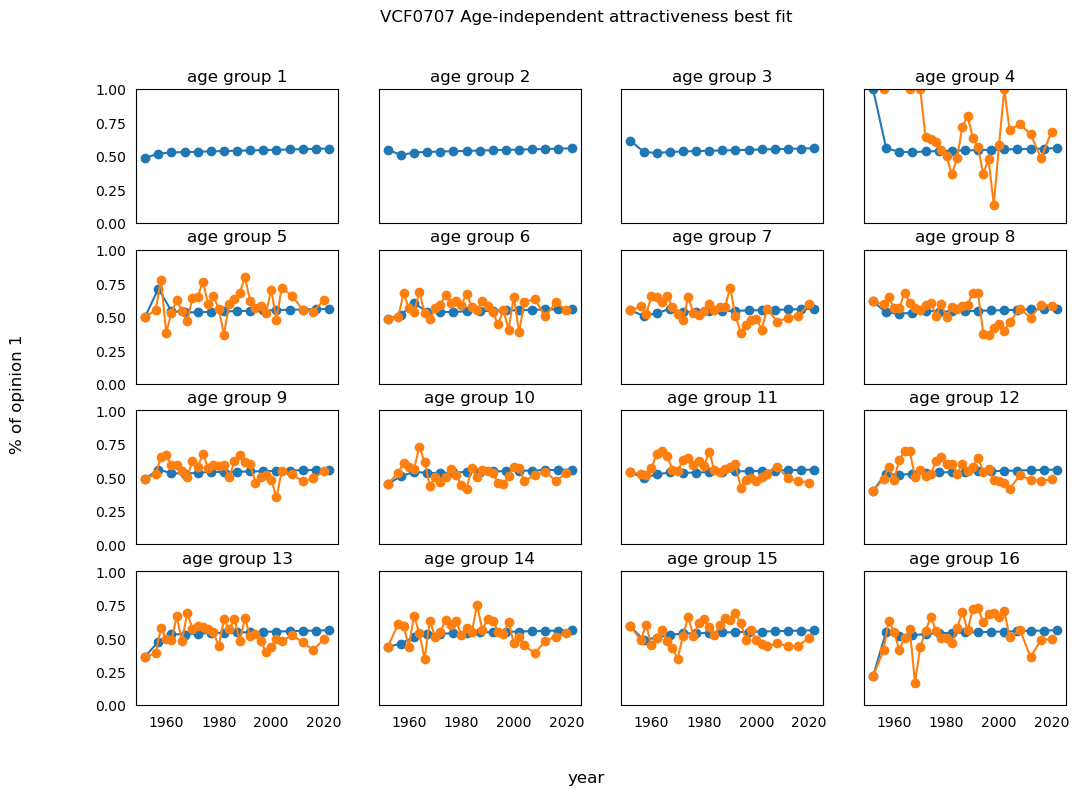

In [322]:
be = (csopt[0] + csopt[1]) * np.ones(N)
ga = (csopt[0] - csopt[1]) * np.ones(N)
# sanity check
for i in range(1, N):
    if be[i]*sum(W[i,:]) > 1 or ga[i]*sum(W[i, :])>1:
        print('Warning')
p = sim(be, ga)
# time series graph for every age group
fig, axs = plt.subplots(4,4, sharex = True, sharey = True, figsize = (12,8))
for k in range(16):
    [i,j] = np.unravel_index(k,[4,4])
    axs[i,j].plot(taxis,p[k,:],'-o')
    if k in range(3,16):
        axs[i,j].plot(t,In[:,3,k-3],'-o')
    #axs[i,j].plot(t,In[:,3,k],'-o')
    axs[i,j].tick_params(left = False, bottom = False)
    axs[i,j].set_title('age group '+str(k+1))
    axs[i,j].set_ylim(0,1)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.suptitle(varname + ' Age-independent attractiveness best fit')
fig.supxlabel('year')
fig.supylabel('% of opinion 1')
plt.savefig('2opinionweightedfits/case1fitWc'+varname+'.jpg')
plt.show()

In [323]:
# linear, coordinated model
i = 0
nt = 500
paramrec = np.zeros((3,nt))
costrec = np.zeros(nt)
while i < nt:
    init = np.zeros(3)
    if i == 0:
        init[0] = csopt[0]
        init[1] = csopt[1]
        init[2] = 0
    else:
        init[0] = random.uniform(0,0.1)
        init[1] = random.uniform(-0.1,0.1)
        init[2] = random.uniform(-0.001, 0.001)
    beinit = (init[0]+init[1])*np.ones(N) + init[2] * np.arange(0, N)
    gainit = (init[0] - init[1])*np.ones(N) - init[2] * np.arange(0, N)
    safe = True
    for j in range(1, N):
        if beinit[j]*sum(W[j,:])>1 or gainit[j]*sum(W[j,:])>1:
            safe = False
            break
    if safe and min(beinit) > 0 and max(beinit) < 1 and min(gainit) > 0 and max(gainit) < 1:
        paramrec[:, i] = init
        costrec[i] = Jlsc(init)
        params, costs = grad_descent(Jlsc,init,'lsc')
        lcopt = params[-1]
        be = (lcopt[0] + lcopt[1]) * np.ones(N) + lcopt[2] * np.arange(0, N)
        ga = (lcopt[0] - lcopt[1]) * np.ones(N) - lcopt[2] * np.arange(0, N)
        safe = True
        for j in range(1, N):
            if be[j]*sum(W[j,:]) > 1 or ga[j]*sum(W[j, :])>1:
                safe = False
        if np.isnan(params[-1]).any():
            continue
        if len(costs) >= 1 and min(costs) > 0 and safe:
            paramrec[:,i] = params[-1]
            costrec[i] = costs[-1]
            if i % 100 == 0:
                print(i, min(costrec[:i+1]))
            i += 1
        elif i == 0:
            i += 1

sselc = min(costrec)
besti = np.argmin(costrec)
lcopt = paramrec[:,besti]
print('minimum SSE:',round(sselc,4))
print('parameters:',np.around(lcopt,decimals = 5))

0 3.937333234218007
100 3.9153716516366575
200 3.9153716516366575
300 3.9153716516366575
400 3.915349635055392
minimum SSE: 3.9153
parameters: [ 0.03931 -0.00227  0.00024]


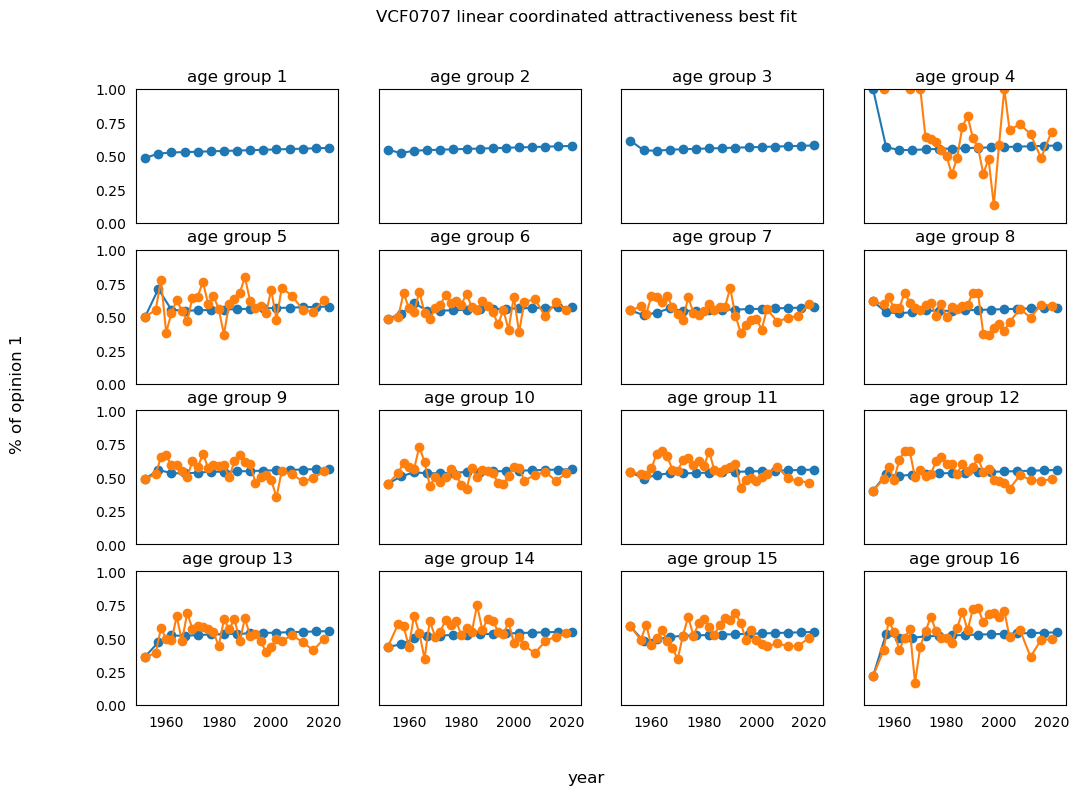

In [324]:
be = (lcopt[0] + lcopt[1]) * np.ones(N) + lcopt[2] * np.arange(0, N)
ga = (lcopt[0] - lcopt[1]) * np.ones(N) - lcopt[2] * np.arange(0, N)
# sanity check
for i in range(1, N):
    if be[i]*sum(W[i,:]) > 1 or ga[i]*sum(W[i, :])>1:
        print('Warning')
p = sim(be, ga)
# time series graph for every age group
fig, axs = plt.subplots(4,4, sharex = True, sharey = True, figsize = (12,8))
for k in range(16):
    [i,j] = np.unravel_index(k,[4,4])
    axs[i,j].plot(taxis,p[k,:],'-o')
    if k in range(3,16):
        axs[i,j].plot(t,In[:,3,k-3],'-o')
    #axs[i,j].plot(t,In[:,3,k],'-o')
    axs[i,j].tick_params(left = False, bottom = False)
    axs[i,j].set_title('age group '+str(k+1))
    axs[i,j].set_ylim(0,1)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.suptitle(varname + ' linear coordinated attractiveness best fit')
fig.supxlabel('year')
fig.supylabel('% of opinion 1')
plt.savefig('2opinionweightedfits/lcfitWc'+varname+'.jpg')
plt.show()

In [325]:
# linear, uncoordinated model
# be = a1 + i*g1, ga = a2 + i*g2
i = 0
nt = 1000
paramrec = np.zeros((4,nt))
costrec = np.zeros(nt)
while i < nt:
    init = np.zeros(4)
    if i == 0:
        init[0] = lcopt[0] + lcopt[1]
        init[1] = lcopt[2]
        init[2] = lcopt[0] - lcopt[1]
        init[3] = -lcopt[2]
    else:
        init[0], init[2] = random.uniform(0,0.1), random.uniform(0,0.1)
        init[1], init[3] = random.uniform(-0.001, 0.001), random.uniform(-0.001, 0.001)
    beinit = init[0] * np.ones(N) + init[1] * np.arange(0, N)
    gainit = init[2] * np.ones(N) + init[3] * np.arange(0, N)
    safe = True
    for j in range(1, N):
        if beinit[j]*sum(W[j,:])>1 or gainit[j]*sum(W[j,:])>1:
            safe = False
            break
    if safe and min(beinit) > 0 and max(beinit) < 1 and min(gainit) > 0 and max(gainit) < 1:
        paramrec[:, i] = init
        costrec[i] = Jlsu(init)
        params, costs = grad_descent(Jlsu,init,'lsu')
        luopt = params[-1]
        be = luopt[0] * np.ones(N) + luopt[1] * np.arange(0, N)
        ga = luopt[2] * np.ones(N) + luopt[3] * np.arange(0, N)
        safe = True
        for j in range(1, N):
            if be[j]*sum(W[j,:]) > 1 or ga[j]*sum(W[j, :])>1:
                safe = False
        if np.isnan(params[-1]).any():
            continue
        if len(costs) >= 1 and min(costs) > 0 and safe:
            paramrec[:,i] = params[-1]
            costrec[i] = costs[-1]
            if i % 100 == 0:
                print(i, min(costrec[:i+1]))
            i += 1
        elif i == 0:
            i += 1

sselu = min(costrec)
besti = np.argmin(costrec)
luopt = paramrec[:,besti]
print('minimum SSE:',round(sselu,4))
print('parameters:',np.around(luopt,decimals = 5))

0 3.9042171268754564
100 3.894600040779012
200 3.886917577224544
300 3.883748190116146
400 3.883748190116146
500 3.883748190116146
600 3.883748190116146
700 3.883748190116146
800 3.883748190116146
900 3.883748190116146
minimum SSE: 3.8829
parameters: [0.03614 0.00128 0.04145 0.00068]


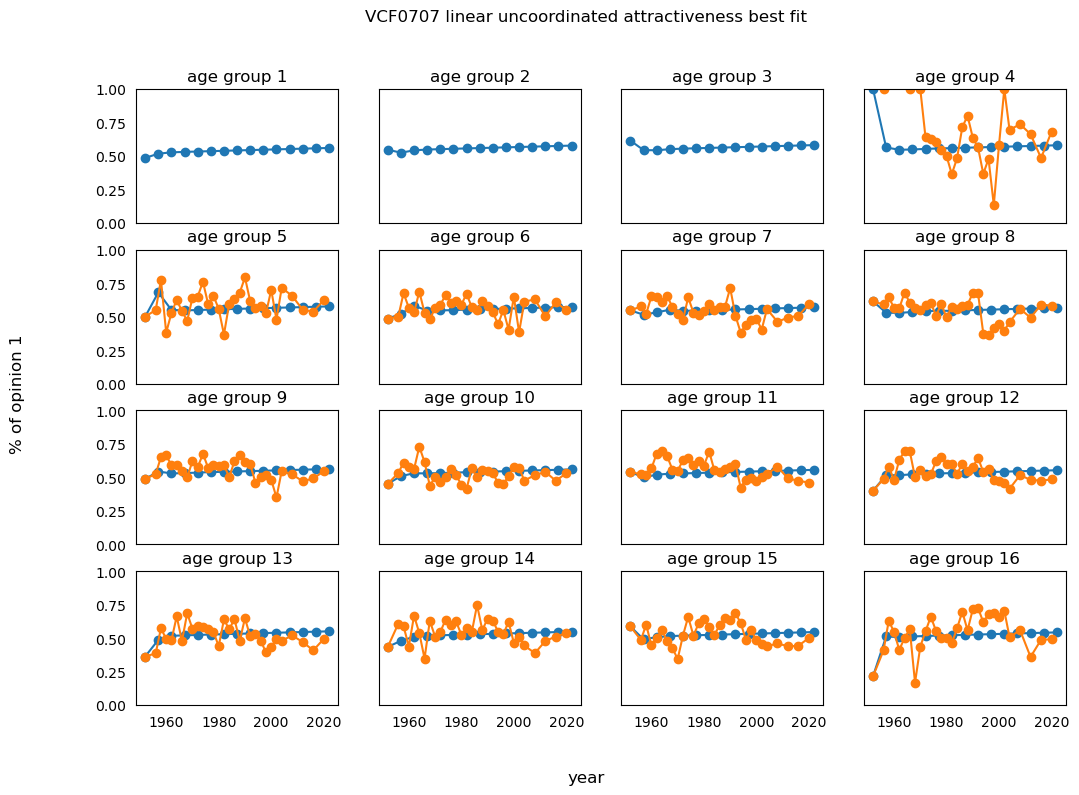

In [326]:
be = luopt[0] * np.ones(N) + luopt[1] * np.arange(0, N)
ga = luopt[2] * np.ones(N) + luopt[3] * np.arange(0, N)
# sanity check
for i in range(1, N):
    if be[i]*sum(W[i,:]) > 1 or ga[i]*sum(W[i, :])>1:
        print('Warning')
p = sim(be, ga)
# time series graph for every age group
fig, axs = plt.subplots(4,4, sharex = True, sharey = True, figsize = (12,8))
for k in range(16):
    [i,j] = np.unravel_index(k,[4,4])
    axs[i,j].plot(taxis,p[k,:],'-o')
    if k in range(3,16):
        axs[i,j].plot(t,In[:,3,k-3],'-o')
    #axs[i,j].plot(t,In[:,3,k],'-o')
    axs[i,j].tick_params(left = False, bottom = False)
    axs[i,j].set_title('age group '+str(k+1))
    axs[i,j].set_ylim(0,1)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.suptitle(varname + ' linear uncoordinated attractiveness best fit')
fig.supxlabel('year')
fig.supylabel('% of opinion 1')
plt.savefig('2opinionweightedfits/lufitWc'+varname+'.jpg')
plt.show()

for i in [6, 4, 2]:
    pcohort = p.diagonal(i)
    c0 = int(taxis[i]) - 20
    c1 = int(c0 + 3)
    cname = str(c0) + '-' + str(c1)
    plt.plot(taxis[i:i+len(pcohort)], pcohort, label = cname)

for i in [0, -2, -4]:
    pcohort = p.diagonal(i)
    c0 = int(taxis[0]) + 4*i - 20
    c1 = int(c0 + 3)
    cname = str(c0) + '-' + str(c1)
    plt.plot(taxis[:len(pcohort)], pcohort, label = cname)

plt.legend()
plt.plot()

In [327]:
# square model
# be = c + a + i * g + i^2 * f
# ga = c - a - i * g - i^2 * f
i = 0
nt = 1000
paramrec = np.zeros((4,nt))
costrec = np.zeros(nt)
while i < nt:
    init = np.zeros(4)
    if i == 0:
        init[0] = lcopt[0]
        init[1] = lcopt[1]
        init[2] = lcopt[2]
        init[3] = 0
    else:
        init[0] = random.uniform(0,0.1)
        init[1] = random.uniform(-0.1,0.1)
        init[2] = random.uniform(-0.001, 0.001)
        init[3] = random.uniform(-0.0001,0.0001)
    beinit = (init[0] + init[1]) * np.ones(N) + init[2] * np.arange(0, N) + init[3] * (np.arange(0,N)**2)
    gainit = (init[0] - init[1]) * np.ones(N) - init[2] * np.arange(0, N) - init[3] * (np.arange(0,N)**2)
    safe = True
    for j in range(1, N):
        if beinit[j]*sum(W[j,:])>1 or gainit[j]*sum(W[j,:])>1:
            safe = False
            break
    if safe and min(beinit) > 0 and max(beinit) < 1 and min(gainit) > 0 and max(gainit) < 1:
        paramrec[:, i] = init
        costrec[i] = Jsquare(init)
        params, costs = grad_descent(Jsquare,init,'square')
        sqopt = params[-1]
        be = (sqopt[0]+sqopt[1]) * np.ones(N) + sqopt[2] * np.arange(0, N) + sqopt[3]*(np.arange(0,N)**2)
        ga = (sqopt[0]-sqopt[1]) * np.ones(N) - sqopt[2] * np.arange(0, N) - sqopt[3]*(np.arange(0,N)**2)
        safe = True
        for j in range(1, N):
            if be[j]*sum(W[j,:]) > 1 or ga[j]*sum(W[j, :])>1:
                safe = False
        if np.isnan(params[-1]).any():
            continue
        if len(costs) >= 1 and min(costs) > 0 and safe:
            paramrec[:,i] = params[-1]
            costrec[i] = costs[-1]
            if i % 100 == 0:
                print(i, min(costrec[:i+1]))
            i += 1
        elif i == 0:
            i += 1

ssesq = min(costrec)
besti = np.argmin(costrec)
sqopt = paramrec[:,besti]
print('minimum SSE:',round(ssesq,4))
print('parameters:',np.around(sqopt,decimals = 5))

0 3.909685534465196
100 3.909685534465196
200 3.898521816840101
300 3.898521816840101
400 3.898521816840101
500 3.898521816840101
600 3.898521816840101
700 3.898521816840101
800 3.898521816840101
900 3.898521816840101
minimum SSE: 3.8985
parameters: [ 3.112e-02 -3.560e-03  8.200e-04 -4.000e-05]


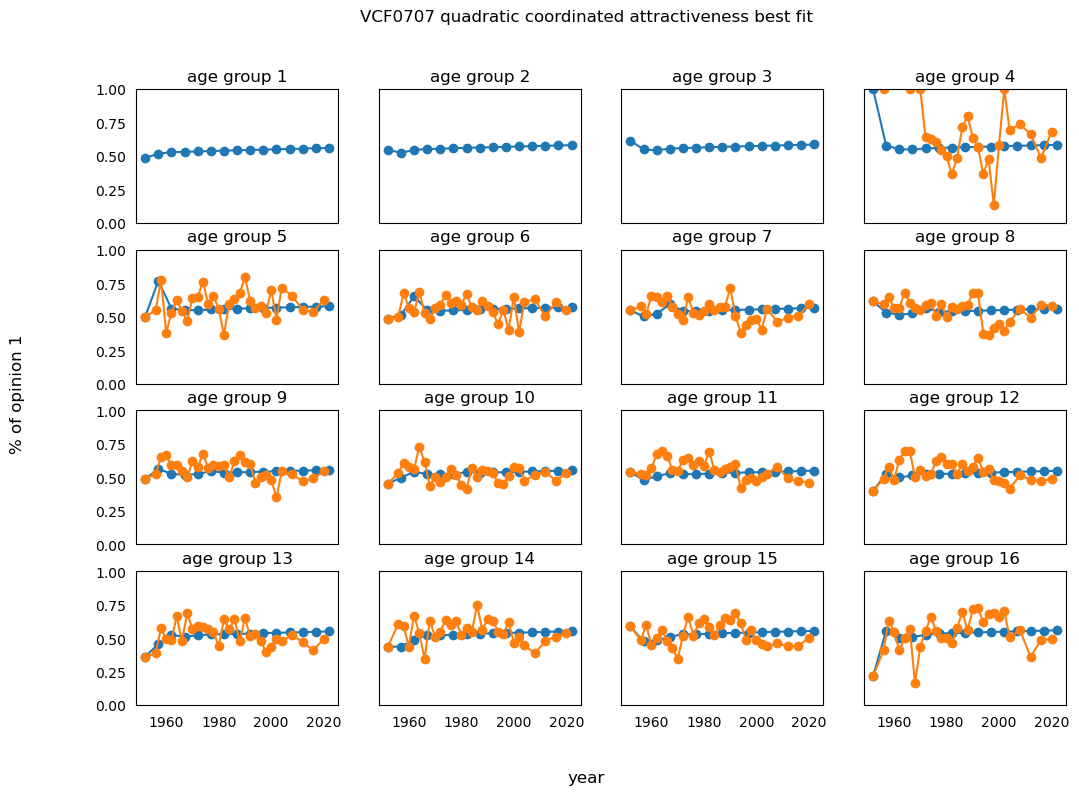

In [328]:
be = (sqopt[0]+sqopt[1]) * np.ones(N) + sqopt[2] * np.arange(0, N) + sqopt[3]*(np.arange(0,N)**2)
ga = (sqopt[0]-sqopt[1]) * np.ones(N) - sqopt[2] * np.arange(0, N) - sqopt[3]*(np.arange(0,N)**2)
p = sim(be, ga)
# sanity check
for i in range(1, N):
    if be[i]*sum(W[i,:]) > 1 or ga[i]*sum(W[i, :])>1:
        print('Warning')
# time series graph for every age group
fig, axs = plt.subplots(4,4, sharex = True, sharey = True, figsize = (12,8))
for k in range(16):
    [i,j] = np.unravel_index(k,[4,4])
    axs[i,j].plot(taxis,p[k,:],'-o')
    if k in range(3,16):
        axs[i,j].plot(t,In[:,3,k-3],'-o')
    #axs[i,j].plot(t,In[:,3,k],'-o')
    axs[i,j].tick_params(left = False, bottom = False)
    axs[i,j].set_title('age group '+str(k+1))
    axs[i,j].set_ylim(0,1)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.suptitle(varname + ' quadratic coordinated attractiveness best fit')
fig.supxlabel('year')
fig.supylabel('% of opinion 1')
plt.savefig('2opinionweightedfits/quadfitWc'+varname+'.jpg')
plt.show()

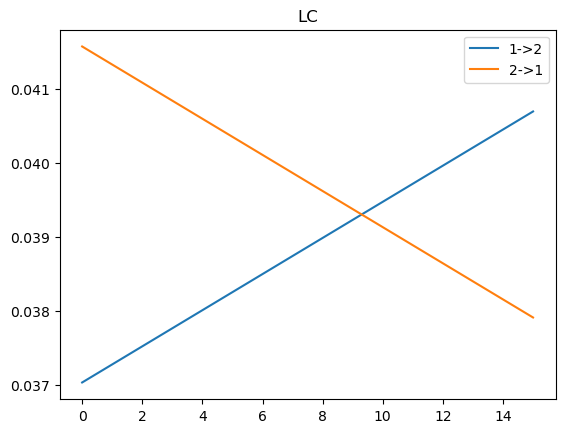

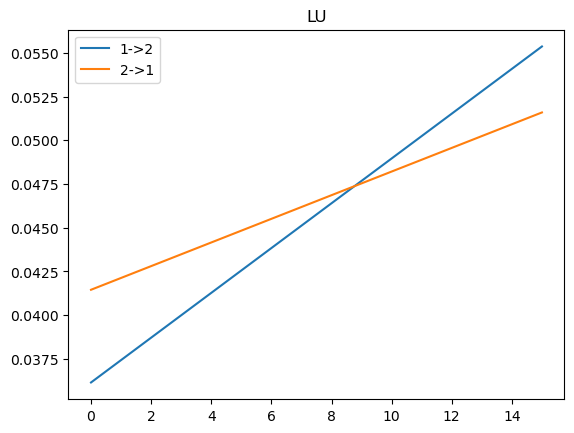

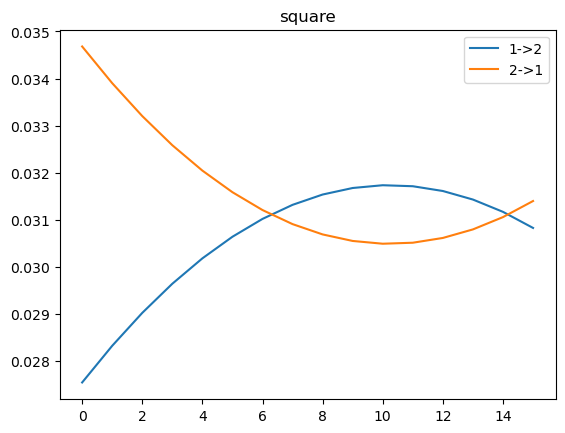

In [329]:
# plot coefficients
# lc
be = (lcopt[0] + lcopt[1]) * np.ones(N) + lcopt[2] * np.arange(0, N)
ga = (lcopt[0] - lcopt[1]) * np.ones(N) - lcopt[2] * np.arange(0, N)
plt.plot(np.arange(0, N), be, label = '1->2')
plt.plot(np.arange(0, N), ga, label = '2->1')
plt.legend()
plt.title('LC')
plt.show()
# lu
be = luopt[0] * np.ones(N) + luopt[1] * np.arange(0, N)
ga = luopt[2] * np.ones(N) + luopt[3] * np.arange(0, N)
plt.plot(np.arange(0, N), be, label = '1->2')
plt.plot(np.arange(0, N), ga, label = '2->1')
plt.legend()
plt.title('LU')
plt.show()
# square
be = (sqopt[0]+sqopt[1]) * np.ones(N) + sqopt[2] * np.arange(0,N) + sqopt[3]*(np.arange(0,N)**2)
ga = (sqopt[0]-sqopt[1]) * np.ones(N) - sqopt[2] * np.arange(0,N) - sqopt[3]*(np.arange(0,N)**2)
plt.plot(np.arange(0, N), be, label = '1->2')
plt.plot(np.arange(0, N), ga, label = '2->1')
plt.legend()
plt.title('square')
plt.show()

# from more complicated models to simpler models
# from square to LC
lcn = sqopt[:3]
beinit = (lcn[0]+lcn[1])*np.ones(N) + lcn[2] * np.arange(0, N)
gainit = (lcn[0]-lcn[1])*np.ones(N) - lcn[2] * np.arange(0,N)
safe = True
for j in range(1, N):
    if beinit[j]*sum(W[j,:])>1 or gainit[j]*sum(W[j,:])>1:
        safe = False
        print('Warning')
        break
if safe and min(beinit) > 0 and max(beinit) < 1 and min(gainit) > 0 and max(gainit) < 1:
    params, costs = grad_descent(Jlsc,lcn,'lsc')
    lcnopt = params[-1]
    be = (lcnopt[0] + lcnopt[1]) * np.ones(N) + lcnopt[2] * np.arange(0, N)
    ga = (lcnopt[0] - lcnopt[1]) * np.ones(N) - lcnopt[2] * np.arange(0, N)
    safe = True
    for j in range(1, N):
        if be[j]*sum(W[j,:]) > 1 or ga[j]*sum(W[j, :])>1:
            safe = False
            print('Warning')
    if np.isnan(params[-1]).any():
        safe = False
    if len(costs) >= 1 and min(costs) > 0 and safe:
        print(costs[-1])
        print(params[-1])

if safe and costs[-1] < sselc:
    sselc = costs[-1]
    lcopt = params[-1]
    be = (lcopt[0] + lcopt[1]) * np.ones(N) + lcopt[2] * np.arange(0, N)
    ga = (lcopt[0] - lcopt[1]) * np.ones(N) - lcopt[2] * np.arange(0, N)
    # sanity check
    for i in range(1, N):
        if be[i]*sum(W[i,:]) > 1 or ga[i]*sum(W[i, :])>1:
            print('Warning')
    p = sim(be, ga)
    # time series graph for every age group
    fig, axs = plt.subplots(4,4, sharex = True, sharey = True, figsize = (12,8))
    for k in range(16):
        [i,j] = np.unravel_index(k,[4,4])
        axs[i,j].plot(taxis,p[k,:],'-o')
        if k in range(3,16):
            axs[i,j].plot(t,In[:,3,k-3],'-o')
        axs[i,j].tick_params(left = False, bottom = False)
        axs[i,j].set_title('age group '+str(k+1))
        axs[i,j].set_ylim(0,1)
        
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

    fig.suptitle(varname + ' linear coordinated attractiveness best fit')
    fig.supxlabel('year')
    fig.supylabel('% of opinion 1')
    plt.savefig('2opinionweightedfits/lcfitWsym'+varname+'.jpg')
    plt.show()

# from LU to LC
c = (luopt[0] + luopt[2])/2
a = (luopt[0] - luopt[2])/2
g = (luopt[1] - luopt[3])/2
lcn = np.array([c, a, g])
beinit = (c+a)*np.ones(N) + g * np.arange(0,N)
gainit = (c-a)*np.ones(N) - g * np.arange(0,N)
safe = True
for j in range(1, N):
    if beinit[j]*sum(W[j,:])>1 or gainit[j]*sum(W[j,:])>1:
        safe = False
        print('Warning')
        break
if safe and min(beinit) > 0 and max(beinit) < 1 and min(gainit) > 0 and max(gainit) < 1:
    params, costs = grad_descent(Jlsc,lcn,'lsc')
    lcnopt = params[-1]
    be = (lcnopt[0] + lcnopt[1]) * np.ones(N) + lcnopt[2] * np.arange(0, N)
    ga = (lcnopt[0] - lcnopt[1]) * np.ones(N) - lcnopt[2] * np.arange(0, N)
    safe = True
    for j in range(1, N):
        if be[j]*sum(W[j,:]) > 1 or ga[j]*sum(W[j, :])>1:
            safe = False
    if np.isnan(params[-1]).any():
        safe = False
    if len(costs) >= 1 and min(costs) > 0 and safe:
        print(costs[-1])
        print(params[-1])

if safe and costs[-1] < sselc:
    sselc = costs[-1]
    lcopt = params[-1]
    be = (lcopt[0] + lcopt[1]) * np.ones(N) + lcopt[2] * np.arange(0, N)
    ga = (lcopt[0] - lcopt[1]) * np.ones(N) - lcopt[2] * np.arange(0, N)
    # sanity check
    for i in range(1, N):
        if be[i]*sum(W[i,:]) > 1 or ga[i]*sum(W[i, :])>1:
            print('Warning')
    p = sim(be, ga)
    # time series graph for every age group
    fig, axs = plt.subplots(4,4, sharex = True, sharey = True, figsize = (12,8))
    for k in range(16):
        [i,j] = np.unravel_index(k,[4,4])
        axs[i,j].plot(taxis,p[k,:],'-o')
        if k in range(3,16):
            axs[i,j].plot(t,In[:,3,k-3],'-o')
        axs[i,j].tick_params(left = False, bottom = False)
        axs[i,j].set_title('age group '+str(k+1))
        axs[i,j].set_ylim(0,1)
        
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

    fig.suptitle(varname + ' linear coordinated attractiveness best fit')
    fig.supxlabel('year')
    fig.supylabel('% of opinion 1')
    plt.savefig('2opinionweightedfits/lcfitWsym'+varname+'.jpg')
    plt.show()

if sselc < sselu:
    init[0] = lcopt[0] + lcopt[1]
    init[1] = lcopt[2]
    init[2] = lcopt[0] - lcopt[1]
    init[3] = -lcopt[2]
    beinit = init[0] * np.ones(N) + init[1] * np.arange(0, N)
    gainit = init[2] * np.ones(N) + init[3] * np.arange(0, N)
    safe = True
    for j in range(1, N):
        if beinit[j]*sum(W[j,:])>1 or gainit[j]*sum(W[j,:])>1:
            safe = False
            break
    if safe and min(beinit) > 0 and max(beinit) < 1 and min(gainit) > 0 and max(gainit) < 1:
        params, costs = grad_descent(Jlsu,init,'lsu')
        luopt = params[-1]
        be = luopt[0] * np.ones(N) + luopt[1] * np.arange(0, N)
        ga = luopt[2] * np.ones(N) + luopt[3] * np.arange(0, N)
        safe = True
        for j in range(1, N):
            if be[j]*sum(W[j,:]) > 1 or ga[j]*sum(W[j, :])>1:
                safe = False
        if np.isnan(params[-1]).any():
            safe = False
        if len(costs) >= 1 and min(costs) > 0 and safe:
            luopt = params[-1]
            sselu = costs[-1]
            print(luopt)
            print(sselu)
            be = luopt[0] * np.ones(N) + luopt[1] * np.arange(0, N)
            ga = luopt[2] * np.ones(N) + luopt[3] * np.arange(0, N)
            # sanity check
            for i in range(1, N):
                if be[i]*sum(W[i,:]) > 1 or ga[i]*sum(W[i, :])>1:
                    print('Warning')
            p = sim(be, ga)
            # time series graph for every age group
            fig, axs = plt.subplots(4,4, sharex = True, sharey = True, figsize = (12,8))
            for k in range(16):
                [i,j] = np.unravel_index(k,[4,4])
                axs[i,j].plot(taxis,p[k,:],'-o')
                if k in range(3,16):
                    axs[i,j].plot(t,In[:,3,k-3],'-o')
                axs[i,j].tick_params(left = False, bottom = False)
                axs[i,j].set_title('age group '+str(k+1))
                axs[i,j].set_ylim(0,1)
                
            # Hide x labels and tick labels for top plots and y ticks for right plots.
            for ax in axs.flat:
                ax.label_outer()

            fig.suptitle(varname + ' linear uncoordinated attractiveness best fit')
            fig.supxlabel('year')
            fig.supylabel('% of opinion 1')
            plt.savefig('2opinionweightedfits/lufitWsym'+varname+'.jpg')
            plt.show()

if sselc < ssesq:
    init[0] = lcopt[0]
    init[1] = lcopt[1]
    init[2] = lcopt[2]
    init[3] = 0
    beinit = (init[0] + init[1]) * np.ones(N) + init[2] * np.arange(0, N) + init[3] * (np.arange(0,N)**2)
    gainit = (init[0] - init[1]) * np.ones(N) - init[2] * np.arange(0, N) - init[3] * (np.arange(0,N)**2)
    safe = True
    for j in range(1, N):
        if beinit[j]*sum(W[j,:])>1 or gainit[j]*sum(W[j,:])>1:
            safe = False
            break
    if safe and min(beinit) > 0 and max(beinit) < 1 and min(gainit) > 0 and max(gainit) < 1:
        params, costs = grad_descent(Jsquare,init,'square')
        sqn = params[-1]
        be = (sqn[0] + sqn[1])*np.ones(N) + sqn[2]*np.arange(0,N) + sqn[3]*np.arange(0,N)**2
        ga = (sqn[0] - sqn[1])*np.ones(N) - sqn[2]*np.arange(0,N) - sqn[3]*np.arange(0,N)**2
        safe = True
        for j in range(1, N):
            if be[j]*sum(W[j,:]) > 1 or ga[j]*sum(W[j, :])>1:
                safe = False
        if np.isnan(params[-1]).any():
            safe = False
        if len(costs) >= 1 and min(costs) > 0 and safe:
            sqopt = params[-1]
            ssesq = costs[-1]
            print(sqopt)
            print(ssesq)
            be = (sqopt[0] + sqopt[1])*np.ones(N) + sqopt[2]*np.arange(0,N) + sqopt[3]*np.arange(0,N)**2
            ga = (sqopt[0] - sqopt[1])*np.ones(N) - sqopt[2]*np.arange(0,N) - sqopt[3]*np.arange(0,N)**2
            # sanity check
            for i in range(1, N):
                if be[i]*sum(W[i,:]) > 1 or ga[i]*sum(W[i, :])>1:
                    print('Warning')
            p = sim(be, ga)
            # time series graph for every age group
            fig, axs = plt.subplots(4,4, sharex = True, sharey = True, figsize = (12,8))
            for k in range(16):
                [i,j] = np.unravel_index(k,[4,4])
                axs[i,j].plot(taxis,p[k,:],'-o')
                if k in range(3,16):
                    axs[i,j].plot(t,In[:,3,k-3],'-o')
                axs[i,j].tick_params(left = False, bottom = False)
                axs[i,j].set_title('age group '+str(k+1))
                axs[i,j].set_ylim(0,1)
                
            # Hide x labels and tick labels for top plots and y ticks for right plots.
            for ax in axs.flat:
                ax.label_outer()

            fig.suptitle(varname + ' quadratic attractiveness best fit')
            fig.supxlabel('year')
            fig.supylabel('% of opinion 1')
            plt.savefig('2opinionweightedfits/quadfitWsym'+varname+'.jpg')
            plt.show()
    

In [330]:
def AIC(k, N, SSE):
    return 2*k + N * math.log(SSE/N)
# number of data points
ndp = np.count_nonzero(~np.isnan(In[:,3,:]))
# AIC score for simplest model
aic1 = AIC(2, ndp, ssecs)
# AIC score for 2nd simplest model
aic2 = AIC(3, ndp, sselc)
aic3 = AIC(4, ndp, sselu)
aic4 = AIC(4, ndp, ssesq)
print('AIC score for simplest model is ', np.around(aic1, decimals=4))
print('AIC score for 2nd simplest model is ', np.around(aic2, decimals=4))
print('AIC score for 3rd model is', np.around(aic3, decimals=4))
print('AIC score for 4th model is', np.around(aic4, decimals=4))
print('Best model is model', np.argmin([aic1, aic2, aic3, aic4])+1)
print('number of data points', ndp)
print('Constant model: ', round(ssecs,4), '\n', np.around(csopt,decimals=5))

print('Linear, coordinated model: ', round(sselc,4), '\n', np.around(lcopt,decimals=5))

print('linear, uncoordinated model: ', round(sselu,4), '\n', np.around(luopt,decimals=5))

print('quadratic coordinated model: ', round(ssesq,4), '\n', np.around(sqopt,decimals=5))

AIC score for simplest model is  -1753.9194
AIC score for 2nd simplest model is  -1754.9234
AIC score for 3rd model is -1756.1208
AIC score for 4th model is -1754.5773
Best model is model 3
number of data points 384
Constant model:  3.9461 
 [ 0.03795 -0.00032]
Linear, coordinated model:  3.9153 
 [ 0.03931 -0.00227  0.00024]
linear, uncoordinated model:  3.8829 
 [0.03614 0.00128 0.04145 0.00068]
quadratic coordinated model:  3.8985 
 [ 3.112e-02 -3.560e-03  8.200e-04 -4.000e-05]
